# Libraries

In [1]:
! pip install -q datasets # install the Hugging Face Datasets library (a wide range of datasets for NLP and other machine learning tasks).

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 5.0 MB/s eta 0:00:00


# Data Collection

### Get data from Kaggle

In [2]:
import os
import zipfile
from google.colab import files

def setup_and_download_kaggle_dataset(competition_name: str):
    """
    Sets up the Kaggle API in Google Colab, uploads kaggle.json,
    downloads the specified dataset, and extracts it.

    Args:
    competition_name (str): The Kaggle competition name (e.g., 'nlp-getting-started').

    Returns:
    List of extracted files.
    """
    # Upload Kaggle API key
    print("Upload your kaggle.json file.")
    files.upload()

    # Create .kaggle directory and move kaggle.json
    kaggle_dir = "/root/.kaggle"
    os.makedirs(kaggle_dir, exist_ok=True)
    !mv kaggle.json {kaggle_dir}/

    # Set permissions for security
    !chmod 600 {kaggle_dir}/kaggle.json

    # Download the dataset
    print(f"Downloading dataset: {competition_name}")
    !kaggle competitions download -c {competition_name}

    # Extract the dataset
    zip_file = f"{competition_name}.zip"
    if os.path.exists(zip_file):
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(competition_name)
        print("Dataset extracted successfully!")
    else:
        print("Error: Dataset zip file not found.")

    # Return the list of extracted files
    extracted_files = os.listdir(competition_name) if os.path.exists(competition_name) else []
    print("Extracted Files:", extracted_files)
    return extracted_files

# Usage
files_list = setup_and_download_kaggle_dataset("us-patent-phrase-to-phrase-matching")

# ['train.csv', 'sample_submission.csv', 'test.csv']

Upload your kaggle.json file.


Saving kaggle.json to kaggle.json
  0% 0.00/682k [00:00<?, ?B/s]
100% 682k/682k [00:00<00:00, 16.7MB/s]
Dataset extracted successfully!
Extracted Files: ['train.csv', 'sample_submission.csv', 'test.csv']


### Read data

In [93]:
import numpy as np
import pandas as pd

def load_csv_data(dataset_name: str, csv_file: str = None):
    """
    Loads CSV data from a given dataset directory.

    Args:
    dataset_name (str): The folder containing the dataset.
    csv_file (str, optional): The specific CSV file to read (for chunked/efficient reading).

    Returns:
    train_df, test_df: train and test DataFrames.
    """
    # TODO: (improve): check train, test, and other files based on filename check (regex) and return the dataset
    print("Reading full train and test datasets...")
    train_df = pd.read_csv(f"{dataset_name}/train.csv")
    test_df = pd.read_csv(f"{dataset_name}/test.csv")
    return train_df, test_df

# Usage:
# Load full dataset
train_df, test_df = load_csv_data("us-patent-phrase-to-phrase-matching")
train_df.info()

Reading full train and test datasets...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36473 entries, 0 to 36472
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       36473 non-null  object 
 1   anchor   36473 non-null  object 
 2   target   36473 non-null  object 
 3   context  36473 non-null  object 
 4   score    36473 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.4+ MB


In [94]:
# only for development
# Select 25% of the data
train_df = train_df.sample(frac=0.05, random_state=42)

# Reset index
train_df = train_df.reset_index(drop=True)

# Understanding Data

In [48]:
train_df.head()

,id,anchor,target,context,score
0,ed1c4e525eb105fe,transmit alarm,display indicator,G08,0.00
1,5386316f318f5221,locking formation,retaining element,B60,0.25
2,1544ca6753fcbddd,lateral power,transducer,H01,0.25
3,f9d8979b94cec923,spreader body,spreader,A01,0.75
4,e151ca5ea5cc0f08,high gradient magnetic separators,magnetic filtration,B03,0.50


* id - a unique identifier for a pair of phrases
* anchor - the first phrase
* target - the second phrase
* context - the CPC classification (version 2021.05), which indicates the subject within which the similarity is to be scored
* score - the similarity. This is sourced from a combination of one or more manual expert ratings.

In [95]:
train_df.describe(include='object')

,id,anchor,target,context
count,1824,1824,1824,1824
unique,1824,618,1771,105
top,ed1c4e525eb105fe,component composite coating,reduction,H04
freq,1,15,4,100


### Task formulation

Since the semantic similarity task can be categorized as a classification problem, I will use a classification modeling approach. The input format I am using is:

"TEXT1: [context text]; TEXT2: [target text]" → Choose a category: "Different, Similar, Identical"

In [96]:
train_df['input'] = 'TEXT1: ' + train_df.context + '; TEXT2: ' + train_df.target + '; ANC1: ' + train_df.anchor
train_df.input.head()

,input
0,TEXT1: G08; TEXT2: display indicator; ANC1: tr...
1,TEXT1: B60; TEXT2: retaining element; ANC1: lo...
2,TEXT1: H01; TEXT2: transducer; ANC1: lateral p...
3,TEXT1: A01; TEXT2: spreader; ANC1: spreader body
4,TEXT1: B03; TEXT2: magnetic filtration; ANC1: ...


### Tokenization

Using a `Dataset object` from the Hugging Face datasets library is one of the best ways to store and manage datasets for Transformers models.

In [97]:
from datasets import Dataset, DatasetDict

train_ds = Dataset.from_pandas(train_df)
train_ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 1824
})

I use:

* AutoTokenizer ensures efficient, error-free tokenization, and
* microsoft/deberta-v3-small is a powerful, lightweight transformer model optimized for NLP tasks.

This combination is ideal for fast, accurate, and scalable NLP applications!

In [68]:
model_nm = 'microsoft/deberta-v3-small'

In [98]:
# 17s = microsoft/deberta-v3-small
from transformers import AutoModelForSequenceClassification, AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


The tok_func function applies tokz(x["input"]), where tokz is an instance of AutoTokenizer. Tokenizers in Hugging Face Transformers return a dictionary containing:

* input_ids – Tokenized numerical representation of the text (word IDs from the model’s vocabulary).
* token_type_ids – Used in sentence-pair tasks (e.g., Next Sentence Prediction). It distinguishes the first sentence from the second (not always needed).
* attention_mask – Indicates which tokens should be attended to (1) and which are padding (0) (helps the model ignore padding tokens).

In [99]:
# adding numerical representations of text, which is required for training transformer models.
# These extra columns enable proper model input during fine-tuning.
def tok_func(x): return tokz(x["input"])

tok_ds = train_ds.map(tok_func, batched=True)

Map:   0%|          | 0/1824 [00:00<?, ? examples/s]

This adds a new item to our dataset called `input_ids`. For instance, here is the input and IDs for the first row of our data:

In [ ]:
# row = tok_ds[0]
# row['input'], row['input_ids']

Finally, we need to prepare our labels. Transformers always assumes that your labels has the column name `labels`, but in our dataset it's currently `score`. Therefore, we need to rename it:

In [100]:
tok_ds = tok_ds.rename_columns({'score':'labels'})

# Test and Validation Sets

### Validation set

Transformers uses a `DatasetDict` for holding your training and validation sets. To create one that contains 25% of our data for the validation set, and 75% for the training set, use `train_test_split`:

In [101]:
tok_dataset_dict = tok_ds.train_test_split(0.25, seed=42)

tok_dataset_dict

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1368
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 456
    })
})

### Test set

In [102]:
test_df.describe()

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,el display,inorganic photoconductor drum,G02
freq,1,2,1,3


In [113]:
test_df['input'] = 'TEXT1: ' + test_df.context + '; TEXT2: ' + test_df.target + '; ANC1: ' + test_df.anchor
test_ds = Dataset.from_pandas(test_df).map(tok_func, batched=True)

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

# Metrics and Correlation

In Kaggle, however, it's very straightforward to know what metric to use: Kaggle will tell you! According to this competition's [evaluation page](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/overview/evaluation), "*submissions are evaluated on the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) between the predicted and actual similarity scores*." This coefficient is usually abbreviated using the single letter *r*. It is the most widely used measure of the degree of relationship between two variables.

r can vary between `-1`, which means perfect inverse correlation, and `+1`, which means perfect positive correlation. The mathematical formula for it is much less important than getting a good intuition for what the different values look like.

Therefore, we'll create this little function to just return the single number we need given a pair of variables:

In [104]:
def corr(x,y): return np.corrcoef(x,y)[0][1]

Transformers expects metrics to be returned as a `dict`, since that way the trainer knows what label to use, so let's create a function to do that:

In [105]:
def corr_d(eval_pred): return {'pearson': corr(*eval_pred)}

# Load Model

🔹I need to Speed Up my Training process for Development:

* Use a Smaller Model – Instead of microsoft/deberta-v3-small, try distilbert-base-uncased (faster and lighter).

* Reduce Dataset Size – Use a small subset of your dataset instead of the full set.

* Lower Batch Size – Reduce per_device_train_batch_size (e.g., bs=16).

* Train for Fewer Steps – Set num_train_epochs=1 or even max_steps=500.

* Disable Mixed Precision (if needed) – Set fp16=False if your hardware struggles.

* Use train_test_split for Quick Evaluation – Instead of using the full test set.

* Use no_cuda=True for CPU Debugging – If running on CPU (slow but avoids GPU overhead for small tests).

In [23]:
from transformers import TrainingArguments, Trainer

We pick a batch size that fits our GPU, and small number of epochs so we can run experiments quickly:

In [106]:
# bs = 128
bs = 16  # development

# epochs = 4
epochs = 1  # development

The most important hyperparameter is the learning rate. fastai provides a learning rate finder to help you figure this out, but Transformers doesn't, so you'll just have to use trial and error. The idea is to find the largest value you can, but which doesn't result in training failing.

In [107]:
# lr = 8e-5
lr = 5e-5  # Lower learning rate  # development

Transformers uses the `TrainingArguments` class to set up arguments. Don't worry too much about the values we're using here -- they should generally work fine in most cases. It's just the 3 parameters above that you may need to change for different models.

In [108]:
args = TrainingArguments(
    'outputs',
    learning_rate=lr,
    warmup_ratio=0.1,
    lr_scheduler_type='cosine',
    # fp16=True,
    fp16=False,  # development
    # eval_strategy="epoch",
    eval_strategy="steps",  # Evaluate more frequently (or "no" to skip)  # development
    per_device_train_batch_size=bs,
    per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs,
    weight_decay=0.01,
    report_to='none',
    save_strategy="no",  # Avoid saving checkpoints to speed up
    logging_steps=50,  # Log progress every 50 steps
    max_steps=500  # Train only for 500 steps
)

In [ ]:
from transformers import TrainerCallback

# Create a dictionary to store training progress
history = {
    "Epoch": [],
    "Training Loss": [],
    "Validation Loss": [],
    "Pearson": []
}

class LoggingCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        # Store training loss
        train_loss = state.log_history[-1].get("loss", None)
        val_loss = state.log_history[-1].get("eval_loss", None)
        pearson_corr = state.log_history[-1].get("eval_pearson", None)

        history["Epoch"].append(state.epoch)
        history["Training Loss"].append(train_loss)
        history["Validation Loss"].append(val_loss)
        history["Pearson"].append(pearson_corr)

        print(f"Epoch {state.epoch}: Train Loss = {train_loss}, Val Loss = {val_loss}, Pearson = {pearson_corr}")

We can now create our model, and `Trainer`, which is a class which combines the data and model together (just like `Learner` in fastai):

In [109]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)

trainer = Trainer(
    model,
    args,
    train_dataset=tok_dataset_dict['train'],
    eval_dataset=tok_dataset_dict['test'],
    processing_class=tokz,
    compute_metrics=corr_d,
    callbacks=[LoggingCallback()]
)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Train and Test

In [111]:
trainer.train();

Step,Training Loss,Validation Loss,Pearson
50,0.074200,0.083579,0.602412
100,0.053500,0.040733,0.675561
150,0.044200,0.051567,0.694459
200,0.029400,0.042408,0.737755
250,0.028900,0.033421,0.751174
300,0.017600,0.034700,0.746432
350,0.017100,0.031445,0.759061
400,0.011800,0.031317,0.759684
450,0.012500,0.032585,0.763025
500,0.009800,0.032028,0.762779


In [117]:
# Convert history to DataFrame & save to CSV
result_data_df = pd.DataFrame(history)

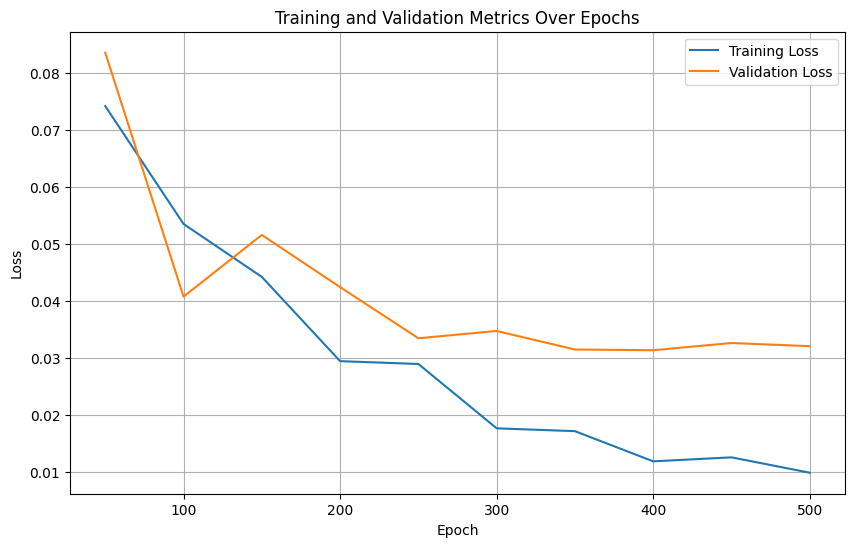

In [131]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(result_data_df['Epoch'], result_data_df['Training Loss'], label='Training Loss')
plt.plot(result_data_df['Epoch'], result_data_df['Validation Loss'], label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

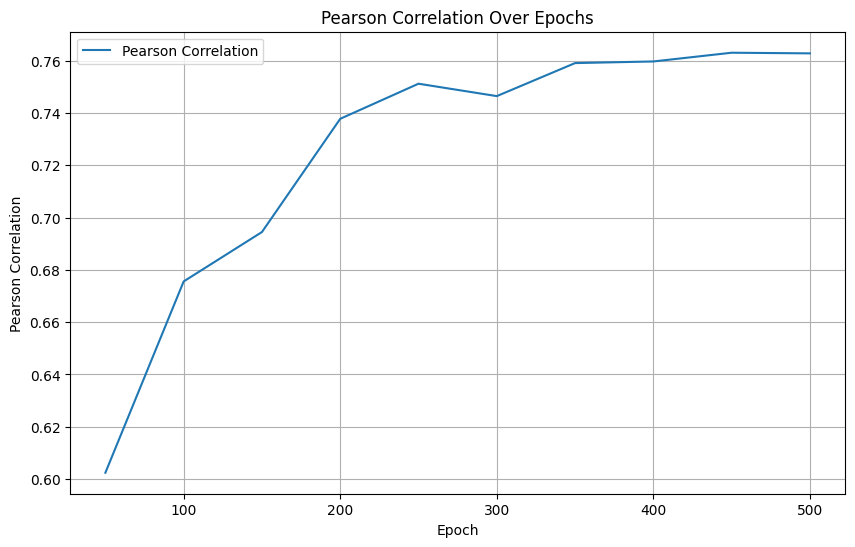

In [132]:
plt.figure(figsize=(10, 6))

plt.plot(result_data_df['Epoch'], result_data_df['Pearson'], label='Pearson Correlation')

plt.xlabel('Epoch')
plt.ylabel('Pearson Correlation')
plt.title('Pearson Correlation Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [114]:
preds = trainer.predict(test_ds).predictions.astype(float)
preds

array([[ 0.50345176],
       [ 0.72934687],
       [ 0.57329834],
       [ 0.31547716],
       [ 0.17307276],
       [ 0.46891522],
       [ 0.25279269],
       [ 0.04978255],
       [ 0.39963758],
       [ 0.9928875 ],
       [ 0.1809625 ],
       [ 0.32400754],
       [ 0.69653726],
       [ 0.44138837],
       [ 0.84913063],
       [ 0.37329647],
       [ 0.17945968],
       [ 0.31377837],
       [ 0.4419046 ],
       [ 0.31540933],
       [ 0.46059078],
       [ 0.22380453],
       [ 0.28123119],
       [ 0.15251639],
       [ 0.55623758],
       [-0.01634053],
       [-0.06286775],
       [ 0.1362012 ],
       [-0.05252833],
       [ 0.34098658],
       [ 0.27802005],
       [ 0.13901581],
       [ 0.80984414],
       [ 0.44727391],
       [ 0.42252317],
       [ 0.13085774]])

Look out - some of our predictions are <0, or >1! This once again shows the value of remember to actually *look* at your data. Let's fix those out-of-bounds predictions:

In [115]:
preds = np.clip(preds, 0, 1)
preds

array([[0.50345176],
       [0.72934687],
       [0.57329834],
       [0.31547716],
       [0.17307276],
       [0.46891522],
       [0.25279269],
       [0.04978255],
       [0.39963758],
       [0.9928875 ],
       [0.1809625 ],
       [0.32400754],
       [0.69653726],
       [0.44138837],
       [0.84913063],
       [0.37329647],
       [0.17945968],
       [0.31377837],
       [0.4419046 ],
       [0.31540933],
       [0.46059078],
       [0.22380453],
       [0.28123119],
       [0.15251639],
       [0.55623758],
       [0.        ],
       [0.        ],
       [0.1362012 ],
       [0.        ],
       [0.34098658],
       [0.27802005],
       [0.13901581],
       [0.80984414],
       [0.44727391],
       [0.42252317],
       [0.13085774]])

# Output

OK, now we're ready to create our submission file. If you save a CSV in your notebook, you will get the option to submit it later.

In [ ]:
# import datasets

# submission = datasets.Dataset.from_dict({
#     'id': eval_ds['id'],
#     'score': preds
# })

# submission.to_csv('submission.csv', index=False)